In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nlp_functions as NF

from sentence_transformers import SentenceTransformer

from sklearn.svm import SVC
from sklearn.metrics import pairwise_distances
from sklearn.naive_bayes import BernoulliNB

from constants import DATA_DIR, RANDOM_SEED

In [2]:
def distance_cluster(df, encoded, known):
    # Assign Clusters Based on Prototypes
    distances = pairwise_distances(encoded[known], encoded[~known])
    dmax = np.max(distances)
    dmin = np.min(distances)
    nearest = np.argmin(distances, axis=0)
    prob = 1-(np.min(distances, 0)-dmin)/(dmax-dmin)

    # Get labels of nearest labeled points
    pred_labels = df.loc[known, 'relevant'].values[nearest]
    return pred_labels, np.vstack((prob, prob)).T # np.ones((len(pred_labels), 2)) # *0.75


def model_fit_predict(model, df, encoded, known):
    try:
        # Provide random seed for reproducibility, if relevent
        M = model(random_state=RANDOM_SEED, probability=True)
    except TypeError:
        M = model()
    M.fit(encoded[known], df.loc[known, 'relevant'].astype(int))

    return M.predict(encoded[~known]), M.predict_proba(encoded[~known])


def ensemble_fit_predict(df, encoded):
    # "relevant" column contains manually generated labels for training
    # "labeled" column contains both manually generated and predicted labels

    models = [distance_cluster, SVC, BernoulliNB]

    known = ~df['relevant'].isna()

    preds = []
    probs = []
    for i, model in enumerate(models):
        if i == 0:
            pred, prob = model(df, encoded, known)
        else:
            pred, prob = model_fit_predict(model, df, encoded, known)
        preds.append(pred)
        probs.append(prob)

    df['predicted'] = np.nan
    # Copy known labels
    df.loc[known, 'predicted'] = df.loc[known, 'relevant'].astype(bool)
    # Fill in new predictions
    df.loc[~known, 'predicted'] = np.mean(preds, axis=0)>0.5
    # Fill in confidence of new predictions
    df.loc[~known, 'confidence'] = np.max(np.mean(np.array(probs), 0), 1)

In [3]:
# Read manually labeled data and all relevant products
manual_labeled = pd.read_parquet(os.path.join(DATA_DIR, 'partial_labeled_100.par'))
full_data = pd.read_parquet(os.path.join(DATA_DIR, 'fil_products_5rev.par'))
full_data['relevant'] = np.nan
# Copy known labels to relevant products
full_data.loc[full_data.index.isin(manual_labeled.index), 'relevant'] = manual_labeled['relevant']
full_data.loc[full_data.index.isin(manual_labeled.index), 'confidence'] = 1
full_data.sort_values('title', key=lambda x: x.str.len(), inplace=True)

In [4]:
# Use Sentence Transformer to create title embeddings
model = SentenceTransformer('all-MiniLM-L12-v2')
sent_encoded = model.encode(full_data["title"].values, convert_to_tensor=False)

In [5]:
# Train ensemble on encodings and labels for manual_labeled
# and predict on unlabeled portion of full_data
ensemble_fit_predict(full_data, sent_encoded)

In [6]:
NF.print_cat_statistics(full_data, 'predicted')

True: 2279 (81.9%)
False: 503 (18.1%)


In [7]:
def plot_confidence(df):
    # Show estimated model confidence for predicted labels
    counts, bins, bars = plt.hist(df.loc[df['predicted'] == True, 'confidence'], 50, histtype='step')
    plt.hist(df.loc[df['predicted'] == False, 'confidence'], bins, histtype='step')
    plt.yscale('log')
    plt.xlabel('Confidence')
    plt.ylabel('Count (log)')
    plt.title('Predicted Label Confidence')
    plt.legend(['Relevant', 'Irrelevant'])
    plt.gcf().set_size_inches(5, 2.5)
    plt.vlines(0.75, 0, max(counts), 'k', 'dashed')
    plt.text(0.75, max(counts), f"<0.75: \n{sum(df['confidence']<0.75)} ", va='top', ha='right')
    plt.show()

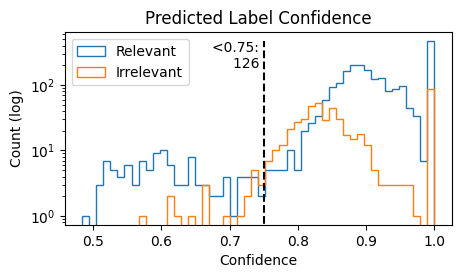

In [8]:
plot_confidence(full_data)

In [9]:
# Reset low-confidence entries
low_confidence_idxs = (full_data['confidence']<0.75)
low_confidence_labels = full_data.loc[low_confidence_idxs, 'predicted']

full_data.loc[full_data['relevant'].isna(), 'relevant'] = 'TBD'
full_data.loc[low_confidence_idxs, 'relevant'] = np.nan

In [10]:
# Manual labeling UI. May take a moment to render
NF.manual_individual_review(full_data)

In [13]:
full_data.loc[low_confidence_idxs, 'confidence'] = 1
full_data.loc[full_data['relevant'] == 'TBD', 'relevant'] = np.nan
NF.print_cat_statistics(full_data, 'relevant')

nan: 2120 (76.2%)
True: 556 (20.0%)
False: 106 (3.8%)


In [14]:
print(sum(full_data['title'].isna()))

0


In [ ]:
full_data.to_parquet(os.path.join(DATA_DIR, 'reviewed_fil_prods.par'))
# full_data = pd.read_parquet(os.path.join(DATA_DIR, 'reviewed_fil_prods.par'))

In [16]:
misclassified = sum(low_confidence_labels != full_data.loc[low_confidence_idxs, 'relevant'])
misclassified

13

In [17]:
# Show misclassified titles
np.array(full_data.loc[low_confidence_idxs, 'title'])[low_confidence_labels != full_data.loc[low_confidence_idxs, 'relevant']]

array(['Creality Ender 3 V2 3D Printer and PLA 3D Printer Filament Black',
       '3doodler 2.0 3d Printing Pen + Free 130 Mixed Strands of Filament PLA & ABS',
       'uxcell PTFE Tubing 3mm ID x 4mm OD x 2M 6.6ft for Filament PLA ABS 3D Printer',
       'da Vinci Mini Wireless 3D Printer-6"x6"x6" Volume (Includes: 300g Filament, PLA/Tough PLA/PETG)',
       'ELEGOO Neptune 3D Printer FDM 3D Printer Full Metal Print Size 8”x8”x8” Compatible with TPU/PLA/ABS Filament',
       '3Doodler Create Mixed Colors ABS 3D Printing Filament Refill Pack (X25 Strands of Plastic) - Bohemian Blend AB-Mix7',
       "3Doodler Start 3D Printing Filament Refill Tube (X100 Strands, Over 830'. of Extruded Plastic!) - Ocean Blue, Compatible with Start 3D Pen for Kids",
       'Tseriact Filament Welder Splicer - 1.75mm 3D Filament Connector Easy Operate Repair Broken 3D Filament for All Kind PLA/ABS/PETG/TPU/PC/PP/Hips Material',
       'Sunhokey 3D Printer Filament Detection Sensor Module Filament Run-Out P

In [ ]:
# Use the updated dataset to make new predictions
new_predictions = full_data.copy(deep=True)
ensemble_fit_predict(new_predictions, sent_encoded)
NF.print_cat_statistics(new_predictions, 'predicted')

In [ ]:
# Save predicted labels
new_predictions.to_parquet(os.path.join(DATA_DIR, 'predicted_fil_prods.par'))

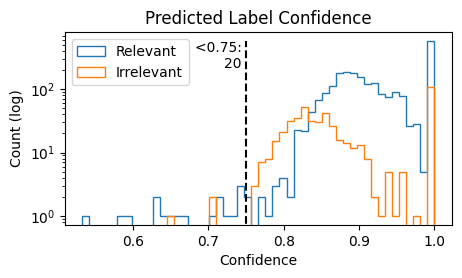

In [ ]:
# Show new confidence estimates
plot_confidence(new_predictions)

In [ ]:
# Show low confidence titles
low_confidence_idxs2 = (new_predictions['confidence']<0.75)
print('Predicted Relevant, Uncertain:')
print(np.array(new_predictions.loc[low_confidence_idxs2*(new_predictions['predicted'].astype(bool)), 'title']))

print('\nPredicted Irrelevant, Uncertain:')
print(np.array(new_predictions.loc[low_confidence_idxs2*(~new_predictions['predicted'].astype(bool)), 'title']))

Predicted Relevant, Uncertain:
['Gizmo Dorks ABS Filament for 3D Printers 1.75mm 5kg, Black'
 'Dremel DF45-ECO-B Eco-ABS 3D Printer Filament, 1.75 mm Diameter, Black'
 'LulzBot Taulman T-Glase PET 3D Printer Filament, 1 lb. Reel, 3 mm, Black'
 'PRILINE ASA 3D Printer Filament, UV and Weather Resistant Filament,1.75mm 1kg Spool,Black ASA'
 'Robotic Steel Metallic Silvery Steel 3D Printing PLA Filament \xa0(1.75mm 0.5 kg) Made in The USA'
 '3Doodler Create PLA 3D Printing Filament Refill Bag (x250 Strands, Over 2000 ft. of Extruded Plastic) - Neon Sunset'
 '3Doodler Create PLA 3D Printing Filament Refill Bag (x250 Strands, Over 2000 ft. of Extruded Plastic) - Bud & Bloom'
 '2.85mm 3D Printing Filament Connector Gen2 3D Printer Accessories Easy Operate for Filament 2.85mm PLA/ABS/PC/PETG/TPU Material…'
 'KIMYA - 3D Printer PLA Filament - 1.75mm - 750g - Consumable and Professional Parts Printing - 100% Recycled - Gray - Made in Europe'
 '3D Pen Filament Fun Pack - 11 Colors - for Use with

In [ ]:
# Load all available reviews
reviews = pd.read_parquet(os.path.join(DATA_DIR, 'reviews.par'))

In [ ]:
# Get the asins for all the predicted relevant products (including manually labeled products)
relevant_asins = new_predictions.index[new_predictions['predicted']].values
relevant_asins

array(['B07CZ6QHBP', 'B07YCR3ZWN', 'B08CZD63BR', ..., 'B07TTKLHQW',
       'B0BNKL5224', 'B07TWP1TRB'], dtype=object)

In [ ]:
# Filter to just the reviews associated with relevant products
relevant_reviews = reviews.loc[reviews['parent_asin'].isin(relevant_asins)]
relevant_reviews.shape

(119019, 9)

In [ ]:
# Save the filtered reviews
relevant_reviews.to_parquet(os.path.join(DATA_DIR, 'relevant_reviews.par'))